# Sesión 2
# Datos Crediticios y Consideraciones Previas al Modelamiento

## Objetivo

En esta sesión vamos a entender:

- Qué tipo de datos existen en banca para credit scoring
- Cuáles son las fuentes típicas de información
- Qué variables se utilizan realmente
- Qué supuestos deben validarse antes de modelar
- Cómo definir correctamente el perímetro del modelo
- Cómo construir coherentemente el target

---

## Mensaje central

Antes de modelar, debemos entender:

1) Qué información tenemos  
2) Qué estamos intentando predecir  
3) Para qué se usará el modelo  


# 1. Tipos de Datos en Credit Scoring

En banca, los datos suelen dividirse en cuatro grandes grupos:

---

## 1.1 Datos Demográficos

- Edad
- Estado civil
- Nivel educativo
- Región
- Antigüedad laboral

Son variables relativamente estables.

---

## 1.2 Datos Financieros

- Ingreso declarado
- Ingreso validado
- Nivel de endeudamiento
- Ratio cuota/ingreso
- Activos

Son variables estructurales de capacidad de pago.

---

## 1.3 Datos Comportamentales (Behavioral)

- Historial de pagos
- DPD histórico
- Utilización de línea
- Número de productos
- Rotación de saldo

Son las variables más predictivas en modelos de comportamiento.

---

## 1.4 Datos de Buró / Externos

- Score externo
- Deudas en otras entidades
- Morosidad externa
- Número de consultas

Permiten capturar riesgo sistémico del cliente.

---

## 1.5 Datos Macroeconómicos (en modelos PIT / IFRS9)

- Desempleo
- Inflación
- PBI
- Tasa de interés

Se usan para ajustar PD al ciclo.


# 2. Fuentes de Información en Banca

Típicamente:

- Core bancario (créditos, pagos, saldos)
- Data warehouse
- Buró de crédito
- CRM
- Información macroeconómica pública
- Modelos internos previos

⚠ Problema frecuente:
La información está distribuida en múltiples sistemas.


# 3. Definición del Perímetro del Modelo

Antes de modelar debemos definir:

- ¿Qué producto?
    - Tarjeta
    - Consumo
    - Hipotecario
- ¿Qué segmento?
    - Retail
    - Pyme
- ¿Qué tipo de modelo?
    - Originación
    - Comportamental
    - Collections

---

Ejemplo:

Modelo de originación consumo no revolvente,
clientes nuevos,
horizonte 12 meses,
default 90 DPD.


# 4. Supuestos y Consideraciones Previas

Antes de modelar debemos validar:

1) Estabilidad histórica del default
2) Calidad de datos (missing, outliers)
3) Representatividad de la muestra
4) Ventanas bien alineadas
5) No leakage temporal
6) Homogeneidad del portafolio
7) Suficiente volumen de defaults

---

Regla práctica:
Menos de 200–300 defaults → modelo inestable.


# 5. Definición del Target

El target debe definir claramente:

- Evento (ej. 90 DPD)
- Horizonte (ej. 12 meses)
- Unidad de análisis (cliente u operación)

Formalmente:

Y_i = 1 si el cliente entra en default dentro de 12 meses
Y_i = 0 en caso contrario

---

La calidad del modelo depende directamente de la calidad del target.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

n = 5000

# Variables demográficas
edad = np.random.normal(40, 10, n)
ingreso = np.random.normal(3000, 800, n)

# Variables financieras
ratio_deuda = np.random.uniform(0.1, 0.8, n)

# Variables comportamentales
utilizacion = np.random.uniform(0.1, 1.0, n)
dpd_hist = np.random.choice([0, 30, 60, 90], n, p=[0.75, 0.12, 0.08, 0.05])

# Construcción probabilidad latente (función logística estructural)
logit = (
    -4
    + 0.02 * (edad - 40)
    + 0.0004 * (3000 - ingreso)
    + 3 * ratio_deuda
    + 2 * utilizacion
    + 0.01 * dpd_hist
)

prob_default = 1 / (1 + np.exp(-logit))

default = np.random.binomial(1, prob_default)

df = pd.DataFrame({
    "edad": edad,
    "ingreso": ingreso,
    "ratio_deuda": ratio_deuda,
    "utilizacion": utilizacion,
    "dpd_hist": dpd_hist,
    "default_12m": default
})

df.head()

,edad,ingreso,ratio_deuda,utilizacion,dpd_hist,default_12m
0,44.967142,2660.992254,0.324879,0.563002,0,0
1,38.617357,2637.268713,0.172113,0.612543,0,0
2,46.476885,1563.485462,0.150265,0.116852,90,0
3,55.230299,2735.927847,0.165993,0.740105,30,1
4,37.658466,3586.263265,0.508009,0.741155,0,0


In [ ]:
pd_modelo = df["default_12m"].mean()
pd_modelo

0.225

In [3]:
df["default_12m"].value_counts(normalize=True)

default_12m
0    0.775
1    0.225
Name: proportion, dtype: float64

C:\Users\Enzo\AppData\Local\Temp\ipykernel_11044\3700867668.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.qcut(df["ratio_deuda"], 5))["default_12m"].mean().plot()


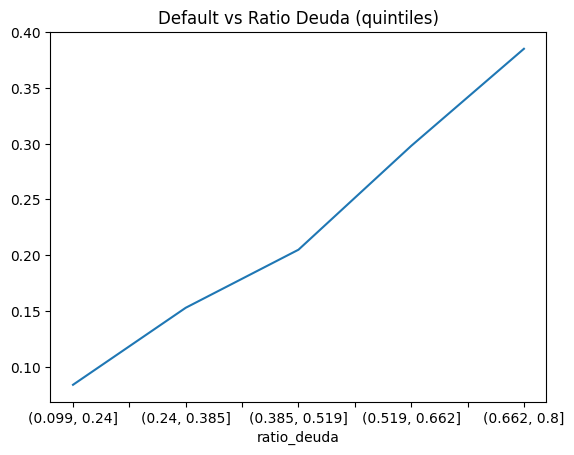

In [ ]:
df.groupby(pd.qcut(df["ratio_deuda"], 5))["default_12m"].mean().plot()
plt.title("Default vs Ratio Deuda (quintiles)")
plt.show()

C:\Users\Enzo\AppData\Local\Temp\ipykernel_11044\2149251018.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_edad = df.groupby("edad_bin")["default_12m"].mean()


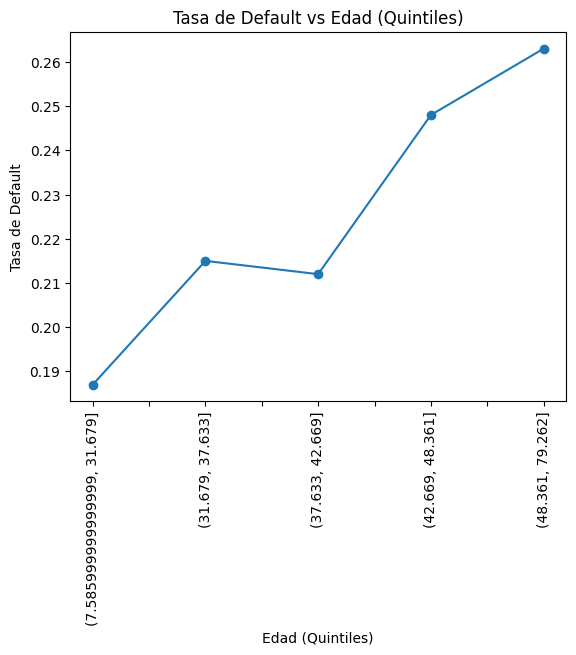

In [6]:
# Binning por quintiles de edad
df["edad_bin"] = pd.qcut(df["edad"], 5)

default_edad = df.groupby("edad_bin")["default_12m"].mean()

default_edad.plot(marker="o")
plt.title("Tasa de Default vs Edad (Quintiles)")
plt.xlabel("Edad (Quintiles)")
plt.ylabel("Tasa de Default")
plt.xticks(rotation=90)
plt.show()